# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Autumn Mitchell 

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

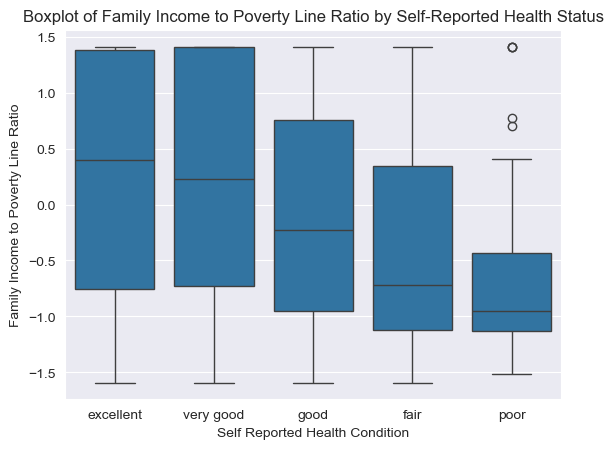

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

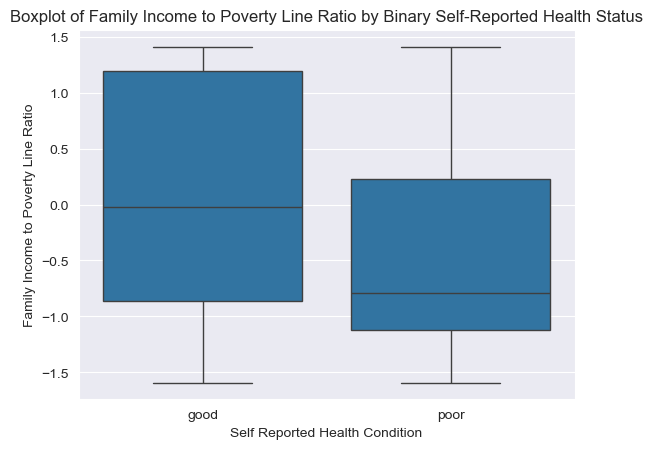

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

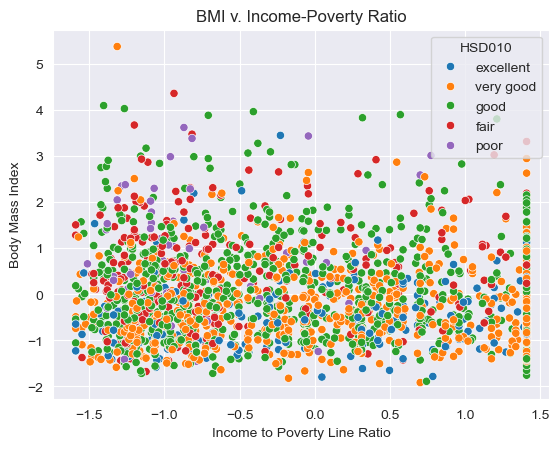

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

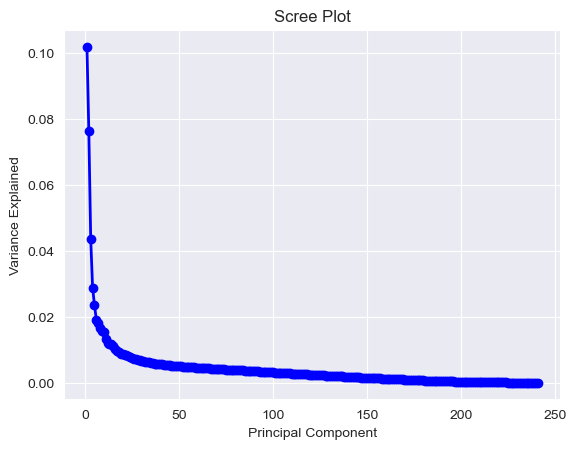

In [7]:
# Create a Scree plot to evaluate the number of components to keep

# fit PCA without a specified number of components 
pca_all = PCA()
principalComponents_nhanes_all = pca_all.fit_transform(nhanes_scaled)

# create scree plot from PCA fit
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Looking at the Skree plot, five principle components explain a good majority of the variance in the data. Any additional components after these first five have increasingly diminishing returns. Therefore, I will use five components to model the data. This is called the eblow test. 

In [8]:
# the data has already been scaled
pca = PCA(n_components=5)
principalComponents_nhanes_scaled = pca.fit_transform(nhanes_scaled)

# Convert into df
pca_df = pd.DataFrame(data = principalComponents_nhanes_scaled, 
                      columns = ['principal component 1', 
                                 'principal component 2',
                                 'principal component 3',
                                 'principal component 4',
                                 'principal component 5'])

# view factor loadings as dataframe
pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,9.527811,-0.816225,-1.867071,-2.110196,-3.928426
1,-5.838339,-3.692572,3.805725,-1.030104,0.391615
2,-0.719454,-2.573201,0.907987,-4.757432,-1.795551
3,3.533627,-2.576981,-3.249148,-0.404502,3.994119
4,-6.872094,-4.194242,0.886909,-0.849657,-0.523221


### Barplot of Components

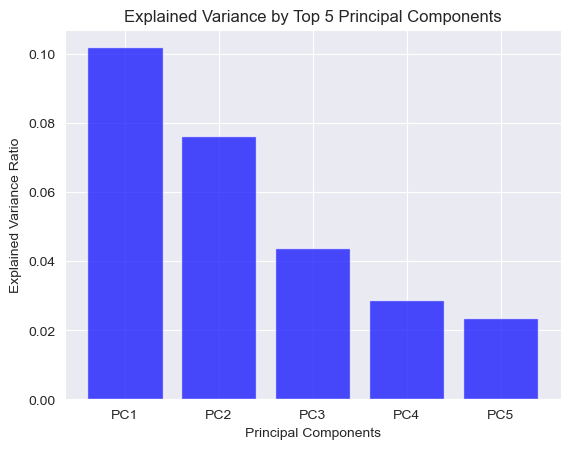

In [9]:
explained_variance = pca.explained_variance_ratio_
components = [f"PC{i+1}" for i in range(len(explained_variance))]
plt.bar(components, explained_variance, alpha=0.7, color='b')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Top 5 Principal Components')
plt.show()

### How many components will you use to fit a supervised learning model?

As described above, I will be using five principle components in this analysis. This number was chosen via the elbow test. 

### 2D Scatterplot of the first two components

Text(0.5, 1.0, 'Scatter Plot of First Two Principal Components')

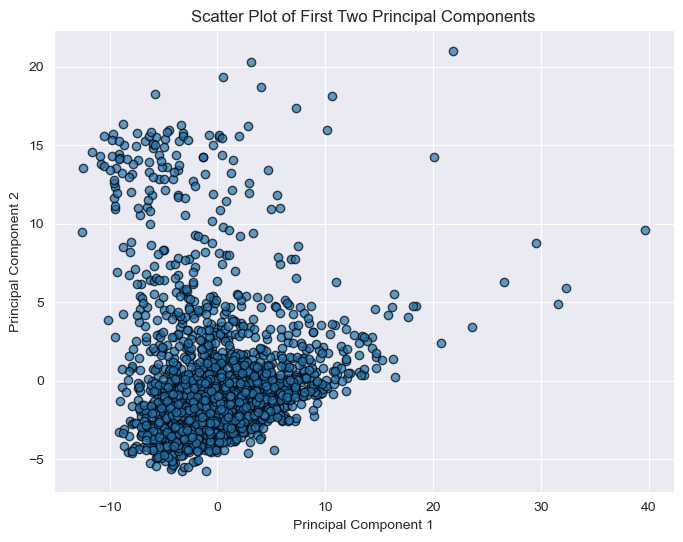

In [19]:
pca = PCA(n_components=2)
principalComponents_nhanes_scaled2 = pca.fit_transform(nhanes_scaled)

pca_df2 = pd.DataFrame(data = principalComponents_nhanes_scaled2, 
                      columns = ['principal component 1', 
                                 'principal component 2'])



plt.figure(figsize=(8, 6))
plt.scatter(pca_df2['principal component 1'], pca_df2['principal component 2'], alpha=0.7, edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of First Two Principal Components')



Looking at the scatterplot of the first two components, it seems like there is clustering of data at lower values of both the first and second principal components. The variance of the first component is greater than the second, considering the scaling of the axes. This makes sense because the first PC always explains the most variance in the data. The points scoring high in the first PC, however, might qualify as outliers given their distance from the rest of the points.


## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I will use a k-means clustering algorithm because this method is quick and scalable. This algorithm clusters data points by minimizing the within-cluster sum of squared distances. It assumes clusters are roughly spherical and equally sized, so this might be a limitation of the choice if the data does not meet this expectation. This algorithm is also sensitive to outliers. 


To figure out how many clusters to run I will employ the elbow method. This method involves analyzing the within-cluster sum of squared distances (WCSS), which measures the compactness of the clusters.


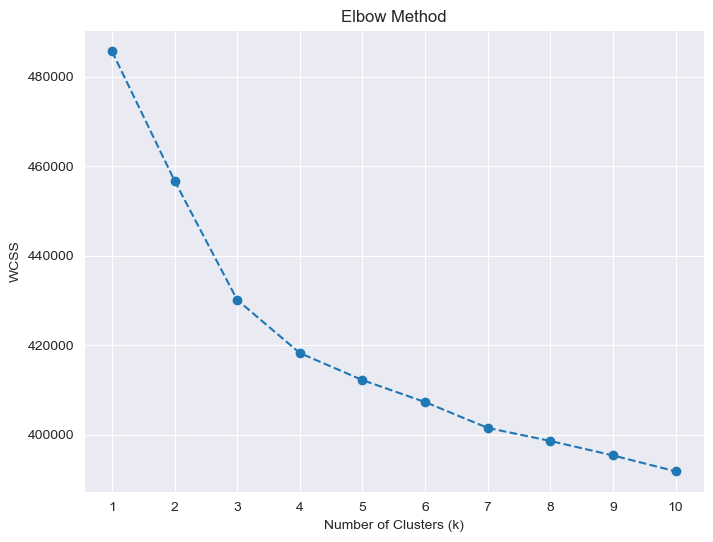

In [25]:
# Compute WCSS for a range of k
wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nhanes_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Interpreting this elbow plot, there seems to be an inflection point at three clusters. Therefore I will use the k means algorithm with three clusters on the nhanes scaled data.

### Cluster nhanes

In [28]:
 # Run K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(nhanes_scaled)

centroids = kmeans.cluster_centers_  # Centroids of clusters
labels = kmeans.labels_  # Cluster assignments for each data point

# Add the cluster labels to nhanes dataframe
nhanes_scaled['cluster'] = kmeans.labels_


### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

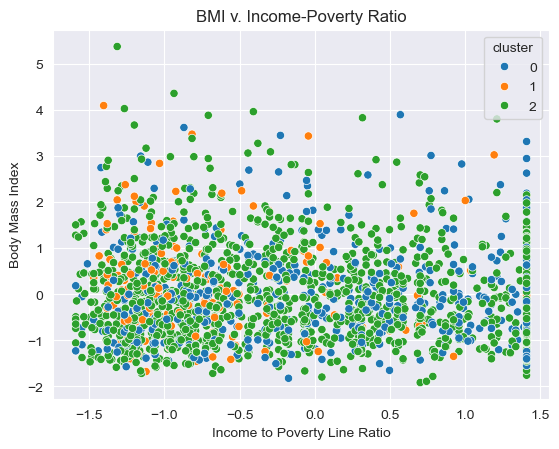

In [29]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "cluster", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Looking at the BMI vs Income-Poverty plot with the points colored based on cluster, the only pattern I see is that points in cluster 1 tend to be a bit lower on the income to poverty line ratio. This might indicate that cluster three is capturing cases lower on the income scale. However, this cluster does not seem to correspond much with BMI. There are no other clear patterns in the plot. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

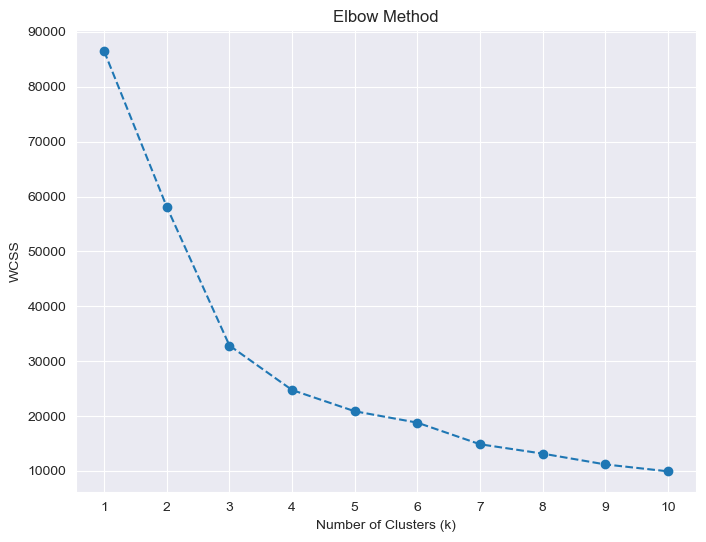

In [26]:
# run the elbow method again on PCA components
wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df2)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_values)
plt.grid(True)
plt.show()

After running the elbow method for the PCA clustering, I decide to use three clusters once again as this appears to be the inflection point in the above plot. 

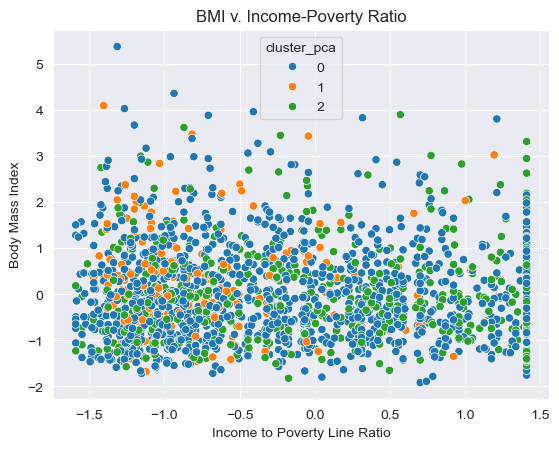

In [31]:
 # Run K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pca_df2)

centroids = kmeans.cluster_centers_  # Centroids of clusters
labels = kmeans.labels_  # Cluster assignments for each data point

# Add the cluster labels to nhanes dataframe
nhanes_scaled['cluster_pca'] = kmeans.labels_

ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "cluster_pca", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Looking at the clustering results using the first two principal components rather than all of the dimensions of the original dataset, the results look broadly similar. Again, cluster 1 seems to be a bit more concentrated toward the lower side of the income spectrum. Given the fact that PCA reduced the computational load of clustering, and yet does not seem to change the results very much, clustering based on principal components seem like a good option. 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [59]:
hsd010_binary = hsd010.replace(
    [1, 2, 3, 4, 5], [1, 1, 1, 0, 0])


In [68]:
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,cluster,cluster_pca
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,0,2
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,2,0
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2,0
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,0,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,2,0


In [69]:
# partition data
# -----------
y = hsd010_binary
X = nhanes_scaled.drop(['cluster', 'cluster_pca'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [70]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [72]:
# create neural network model
# -----------

num_neuron = 241

model = Sequential()

model.add(Dense(num_neuron, input_dim= num_neuron, kernel_initializer= 'normal', activation='relu'))
model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))
model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 0s - 37ms/step - accuracy: 0.7158 - loss: 0.5576 - val_accuracy: 0.8488 - val_loss: 0.3862
Epoch 2/10
8/8 - 0s - 3ms/step - accuracy: 0.8592 - loss: 0.3546 - val_accuracy: 0.8566 - val_loss: 0.3540
Epoch 3/10
8/8 - 0s - 3ms/step - accuracy: 0.8682 - loss: 0.3139 - val_accuracy: 0.8702 - val_loss: 0.3459
Epoch 4/10
8/8 - 0s - 3ms/step - accuracy: 0.8902 - loss: 0.2804 - val_accuracy: 0.8682 - val_loss: 0.3373
Epoch 5/10
8/8 - 0s - 3ms/step - accuracy: 0.9018 - loss: 0.2494 - val_accuracy: 0.8682 - val_loss: 0.3291
Epoch 6/10
8/8 - 0s - 3ms/step - accuracy: 0.9128 - loss: 0.2261 - val_accuracy: 0.8624 - val_loss: 0.3292
Epoch 7/10
8/8 - 0s - 3ms/step - accuracy: 0.9257 - loss: 0.2034 - val_accuracy: 0.8663 - val_loss: 0.3266
Epoch 8/10
8/8 - 0s - 3ms/step - accuracy: 0.9354 - loss: 0.1842 - val_accuracy: 0.8643 - val_loss: 0.3289
Epoch 9/10
8/8 - 0s - 3ms/step - accuracy: 0.9438 - loss: 0.1670 - val_accuracy: 0.8682 - val_loss: 0.3329
Epoch 10/10
8/8 - 0s - 3ms/step - accuracy: 0.9

### Neural Network on Principal Components

In [75]:
y = hsd010_binary
X = pca_df

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

num_neuron = 5

model = Sequential()

model.add(Dense(num_neuron, input_dim= num_neuron, kernel_initializer= 'normal', activation='relu'))
model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))
model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 0s - 36ms/step - accuracy: 0.8178 - loss: 0.6797 - val_accuracy: 0.8488 - val_loss: 0.6715
Epoch 2/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6672 - val_accuracy: 0.8488 - val_loss: 0.6585
Epoch 3/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6539 - val_accuracy: 0.8488 - val_loss: 0.6449
Epoch 4/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6401 - val_accuracy: 0.8488 - val_loss: 0.6302
Epoch 5/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6248 - val_accuracy: 0.8488 - val_loss: 0.6146
Epoch 6/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6086 - val_accuracy: 0.8488 - val_loss: 0.5978
Epoch 7/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.5912 - val_accuracy: 0.8488 - val_loss: 0.5800
Epoch 8/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.5732 - val_accuracy: 0.8488 - val_loss: 0.5613
Epoch 9/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.5540 - val_accuracy: 0.8488 - val_loss: 0.5423
Epoch 10/10
8/8 - 0s - 2ms/step - accuracy: 0.8

### Neural Network on Principal Components + Cluster Membership

In [111]:
pca_df['cluster'] = nhanes_scaled['cluster'].values

y = hsd010_binary
X = pca_df

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

num_neuron = 6

model = Sequential()

model.add(Dense(num_neuron, input_dim= num_neuron, kernel_initializer= 'normal', activation='relu'))
model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))
model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)


Epoch 1/10


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 0s - 36ms/step - accuracy: 0.8081 - loss: 0.6834 - val_accuracy: 0.8488 - val_loss: 0.6753
Epoch 2/10
8/8 - 0s - 2ms/step - accuracy: 0.8379 - loss: 0.6716 - val_accuracy: 0.8488 - val_loss: 0.6623
Epoch 3/10
8/8 - 0s - 3ms/step - accuracy: 0.8372 - loss: 0.6578 - val_accuracy: 0.8508 - val_loss: 0.6474
Epoch 4/10
8/8 - 0s - 2ms/step - accuracy: 0.8379 - loss: 0.6418 - val_accuracy: 0.8508 - val_loss: 0.6303
Epoch 5/10
8/8 - 0s - 2ms/step - accuracy: 0.8398 - loss: 0.6237 - val_accuracy: 0.8527 - val_loss: 0.6110
Epoch 6/10
8/8 - 0s - 3ms/step - accuracy: 0.8424 - loss: 0.6031 - val_accuracy: 0.8527 - val_loss: 0.5900
Epoch 7/10
8/8 - 0s - 3ms/step - accuracy: 0.8443 - loss: 0.5813 - val_accuracy: 0.8508 - val_loss: 0.5676
Epoch 8/10
8/8 - 0s - 2ms/step - accuracy: 0.8456 - loss: 0.5580 - val_accuracy: 0.8488 - val_loss: 0.5446
Epoch 9/10
8/8 - 0s - 2ms/step - accuracy: 0.8482 - loss: 0.5344 - val_accuracy: 0.8508 - val_loss: 0.5220
Epoch 10/10
8/8 - 0s - 3ms/step - accuracy: 0.8

Out of all three models, the neural network trained on the entire nhanes dataset did the best with an ultimate validation accuracy of 0.868. Because I am not working with a very big dataset, the added computational complexity of using all of the original dimensions does not add much computation time. So, I would go with the first model. 

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA is used for dimentionality reduction, so it summarizes the features. In contrast, clustering is a technique of grouping cases based on similar feature values. So, PCA produces new features while clustering assigns each datapoint to a cluster. 


## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

I did not see any notable differences when I combined PCA and clustering. I might not have seen gains if the principal components and clusters captured similar characteristics of the data and therefore the combination brought redundant information.

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques are useful because they help with dimensionality reduction which then reduces the computational complexity of supervised learning tasks. This is particularly useful when working with big data that contains lots of dimensions. This dimensionality reduction can also help with noise reduction. 